# Problem 2

In [17]:
import pandas as pd
import sqlite3
import zipfile
import tempfile
import os

zip_path = 'mock_resq.db.zip'
db_name = 'mock_resq.db'

class TempDirWrapper:
    """Wrapper for temporary extraction of database zipfile
    """
    
    def __init__(self, zip_path:str, db_name:str):
        self.zip_path = zip_path
        self.db_name = db_name
        self.temp_dir = None
        self.db_path = None

    def __enter__(self) -> str:
        self.temp_dir = tempfile.TemporaryDirectory()
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                zip_ref.extractall(self.temp_dir.name)
            self.db_path = os.path.join(self.temp_dir.name, self.db_name)
            return self.db_path
        except Exception as e:
            self.__exit__(None, None, e)
            raise

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.temp_dir:
            self.temp_dir.cleanup()
            
with TempDirWrapper(zip_path=zip_path, db_name=db_name) as db_path:
    # Use db_path here
    with sqlite3.connect(db_path) as conn:
        users = pd.read_sql_query(sql="SELECT * FROM users;", con=conn)
        orders = pd.read_sql_query(sql="SELECT * FROM orders", con=conn)
        providers = pd.read_sql_query(sql="SELECT * FROM providers", con=conn)
        
        
users.registeredDate = pd.to_datetime(users.registeredDate)
users.country = users.country.astype(dtype="category")
users = users.rename(columns={"id": "userId"})

orders.createdAt = pd.to_datetime(orders.createdAt)
for col in ["quantity", "refunded", "sales"]:
    orders[col] = pd.to_numeric(orders[col])

# Lets keep the ids as string. Otherwise there will be problems in joining. 
orders.providerId = orders.providerId.astype(str)
orders = orders.rename(columns={"id": "orderId"})

# Here we joining with right specification since there might be users that have no orders. 
orders = orders.merge(right=users, on="userId", how="right")

orders["t1"]  = (orders.createdAt - orders.registeredDate).dt.days

providers = providers.rename(columns={
    "id":"providerId", 
    "country":"providerCountry"
    })
providers.providerId = providers.providerId.astype(str)
providers.defaultOfferType = providers.defaultOfferType.astype("category")
orders = orders.merge(providers[["providerId", "defaultOfferType","providerCountry"]], on = "providerId", how="left")

## Average Purchase Value (APV)



$$
    \text{APV} = \frac{\text{Total Revenue}}{\text{Number of Orders}}
$$

Based on the data characteristics, I would assume that the prices are in cents rather than the euros. It is a good practice that prevents floating point issues. However, it should be considered when indicators are calculated for the marketing unit.

In this graph there is the histogram of the sales values below 1000. The lack of observations between zero to 100 is the proof of this concept.

<Axes: >

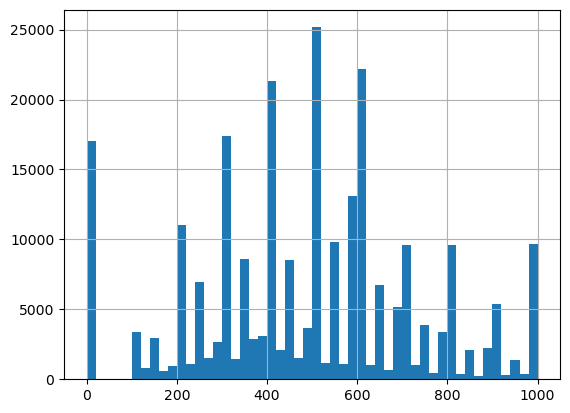

In [18]:
orders.query("sales <= 1000").sales.hist(bins=50)

In [19]:
APV = (
    orders
    .groupby(
        by=["providerCountry","defaultOfferType","currency"], 
        observed=True
        )
    .agg(func={
        "sales":"sum",
        "orderId":"count"
        })
    .assign(APV = lambda x: ((x.sales/100) / x.orderId).round(3))
    [["APV"]]
    .reset_index()
)
APV

,providerCountry,defaultOfferType,currency,APV
0,deu,meal,eur,3.346
1,est,grocery-bag,eur,5.483
2,est,meal,eur,5.563
3,est,snack,eur,3.892
4,fin,dessert,eur,6.887
5,fin,flowers,eur,3.849
6,fin,grocery-bag,eur,5.652
7,fin,ingredients,eur,6.770
8,fin,meal,eur,6.678
9,fin,snack,eur,4.861


## Average Purchase Frequency Rate (APFR)
$$
    \text{APFR} = \frac{\text{Number of Purchases}}{\text{Number of Customers}}
$$

In [20]:
APFR = (
    orders
    .groupby(
        by=["providerCountry","defaultOfferType","currency"], 
        observed=True
        )
    .agg(func={
            "userId":"nunique",
            "orderId":"nunique"
        })
    .assign(APFR = lambda x: (x.orderId / x.userId).round(3)) 
    [["APFR"]]
    .reset_index()
)
APFR

,providerCountry,defaultOfferType,currency,APFR
0,deu,meal,eur,2.294
1,est,grocery-bag,eur,1.522
2,est,meal,eur,2.740
3,est,snack,eur,1.319
4,fin,dessert,eur,1.107
5,fin,flowers,eur,1.159
6,fin,grocery-bag,eur,2.161
7,fin,ingredients,eur,1.364
8,fin,meal,eur,2.185
9,fin,snack,eur,1.653


## Customer Value (CV)
$$
    \text{CV} = \text{Average Purchase Value} \times \text{Average Purchase Frequency Rate}
$$

In [21]:
CV = (
    APV
    .merge(
        right=APFR, 
        on=["providerCountry","defaultOfferType","currency"], 
        how="inner"
        )
    .assign(CV = lambda x: (x.APV * x.APFR).round(3))
    .drop(columns=["APFR", "APV"])
)
CV

,providerCountry,defaultOfferType,currency,CV
0,deu,meal,eur,7.676
1,est,grocery-bag,eur,8.345
2,est,meal,eur,15.243
3,est,snack,eur,5.134
4,fin,dessert,eur,7.624
5,fin,flowers,eur,4.461
6,fin,grocery-bag,eur,12.214
7,fin,ingredients,eur,9.234
8,fin,meal,eur,14.591
9,fin,snack,eur,8.035


## Average Customer Lifespan (ACL)
Lifespac calculation is based on months. 
$$
    \text{ACL} = \frac{\text{Sum of Customer Lifespan}}{\text{Number of Customers}}
$$

In [22]:
ACL = (
    orders
    .groupby(
        by=["userId","providerCountry","currency"], 
        observed=True
        )
    .agg(func={
        "defaultOfferType":"first",
        "t1":"max"
    })
    .reset_index()
    .groupby(
        by=["providerCountry","defaultOfferType","currency"], 
        observed=True
        )
    .agg({"t1": "sum", "userId": "count"})
    .assign(ACL = lambda x:((x.t1 * 12 / 365) / x.userId).round(3))
    [["ACL"]]
    .reset_index()
)
ACL

,providerCountry,defaultOfferType,currency,ACL
0,deu,meal,eur,23.828
1,est,grocery-bag,eur,7.891
2,est,meal,eur,9.211
3,est,snack,eur,6.603
4,fin,dessert,eur,33.226
5,fin,flowers,eur,34.595
6,fin,grocery-bag,eur,29.156
7,fin,ingredients,eur,29.675
8,fin,meal,eur,30.948
9,fin,snack,eur,32.817


## Customer Lifetime Value (CLV) 

$$
    \text{CLV} = \text{Customer Value}\times \text{Average Customer Lifspan}
$$

In [23]:
CLV = (
    ACL
    .merge(
        right=CV, 
        on=["providerCountry", "defaultOfferType", "currency"], 
        how="inner"
        )
    .assign(CLV=lambda x: (x.CV * x.ACL).round())
    .drop(columns=["ACL", "CV"])
    )
CLV = (
    CLV
    .reset_index(drop=True)
    .groupby(["providerCountry", "defaultOfferType"], observed=True)
    .first()
    .sort_values(["providerCountry","CLV"], ascending=False)
    )
CLV

currency     CLV
providerCountry defaultOfferType                 
swe             meal                  sek  5137.0
                snack                 sek  2996.0
                dessert               sek  2196.0
                grocery-bag           sek  1584.0
fin             meal                  eur   452.0
                grocery-bag           eur   356.0
                ingredients           eur   274.0
                snack                 eur   264.0
                dessert               eur   253.0
                flowers               eur   154.0
est             meal                  eur   140.0
                grocery-bag           eur    66.0
                snack                 eur    34.0
deu             meal                  eur   183.0